In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
import pandas as pd
import numpy as np
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, make_scorer, f1_score
from sklearn.preprocessing import LabelEncoder
from patsy import dmatrices
from imblearn.over_sampling import SMOTE
from itertools import combinations

In [4]:
# Read the datasets
option_data = pd.read_excel("Option Code Information file for UNT - Final.xlsx")
warranty_claim_data = pd.read_excel("Claim Information file for UNT.xlsx")

# Check for Null Values in datasets
option_data
warranty_claim_data
option_data.isnull().sum()
warranty_claim_data.isnull().sum()

# Formatting datasets to merge
option_data.rename(columns={'Truck': 'Truck_ID'}, inplace=True)
warranty_claim_data.rename(columns={'Truck Number': 'Truck_ID'}, inplace=True)
merged_data = pd.merge(option_data, warranty_claim_data, on='Truck_ID')
print(merged_data.info())
merged_data

,Truck,Style,Attribute 1,Attribute 2,Attribute 3,Attribute 4,Attribute 5,Attribute 6,Attribute 7,Attribute 8
0,Truck 1,Style 1,Option 1,Option 83,Option 181,Option 204,Option 264,Option 281,Option 290,Option 294
1,Truck 2,Style 1,Option 2,Option 84,Option 181,Option 205,Option 265,Option 282,Option 291,Option 295
2,Truck 3,Style 1,Option 2,Option 84,Option 181,Option 205,Option 265,Option 282,Option 291,Option 295
3,Truck 4,Style 1,Option 2,Option 84,Option 181,Option 205,Option 265,Option 282,Option 291,Option 295
4,Truck 5,Style 1,Option 2,Option 84,Option 181,Option 205,Option 265,Option 282,Option 291,Option 295
...,...,...,...,...,...,...,...,...,...,...
48299,Truck 48300,Style 7,Option 32,Option 101,Option 187,Option 230,Option 265,Option 285,Option 291,Option 299
48300,Truck 48301,Style 7,Option 34,Option 98,Option 187,Option 217,Option 267,Option 285,Option 291,Option 301
48301,Truck 48302,Style 7,Option 34,Option 98,Option 188,Option 217,Option 267,Option 285,Option 291,Option 301
48302,Truck 48303,Style 7,Option 34,Option 98,Option 188,Option 217,Option 267,Option 285,Option 291,Option 301


,Truck Number,Claim Number,Scale Claim Cost,Scale Labor Cost
0,Truck 4208,Claim 1,Very Low,Very Low
1,Truck 22899,Claim 2,Very Low,Very Low
2,Truck 22899,Claim 3,Very Low,Very Low
3,Truck 9983,Claim 4,Very Low,Very Low
4,Truck 2426,Claim 5,Very Low,Very Low
...,...,...,...,...
123356,Truck 46939,Claim 123357,Very High,High
123357,Truck 46939,Claim 123358,Very High,Medium
123358,Truck 10,Claim 123359,Very High,Medium
123359,Truck 44270,Claim 123360,Very High,High


Truck          0
Style          0
Attribute 1    0
Attribute 2    0
Attribute 3    0
Attribute 4    0
Attribute 5    0
Attribute 6    0
Attribute 7    0
Attribute 8    0
dtype: int64

Truck Number        0
Claim Number        0
Scale Claim Cost    0
Scale Labor Cost    0
dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123361 entries, 0 to 123360
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Truck_ID          123361 non-null  object
 1   Style             123361 non-null  object
 2   Attribute 1       123361 non-null  object
 3   Attribute 2       123361 non-null  object
 4   Attribute 3       123361 non-null  object
 5   Attribute 4       123361 non-null  object
 6   Attribute 5       123361 non-null  object
 7   Attribute 6       123361 non-null  object
 8   Attribute 7       123361 non-null  object
 9   Attribute 8       123361 non-null  object
 10  Claim Number      123361 non-null  object
 11  Scale Claim Cost  123361 non-null  object
 12  Scale Labor Cost  123361 non-null  object
dtypes: object(13)
memory usage: 12.2+ MB
None


,Truck_ID,Style,Attribute 1,Attribute 2,Attribute 3,Attribute 4,Attribute 5,Attribute 6,Attribute 7,Attribute 8,Claim Number,Scale Claim Cost,Scale Labor Cost
0,Truck 1,Style 1,Option 1,Option 83,Option 181,Option 204,Option 264,Option 281,Option 290,Option 294,Claim 13675,Low,Low
1,Truck 1,Style 1,Option 1,Option 83,Option 181,Option 204,Option 264,Option 281,Option 290,Option 294,Claim 18104,Low,Low
2,Truck 1,Style 1,Option 1,Option 83,Option 181,Option 204,Option 264,Option 281,Option 290,Option 294,Claim 20261,Low,Low
3,Truck 1,Style 1,Option 1,Option 83,Option 181,Option 204,Option 264,Option 281,Option 290,Option 294,Claim 21530,Low,Low
4,Truck 1,Style 1,Option 1,Option 83,Option 181,Option 204,Option 264,Option 281,Option 290,Option 294,Claim 21693,Low,Low
...,...,...,...,...,...,...,...,...,...,...,...,...,...
123356,Truck 48300,Style 7,Option 32,Option 101,Option 187,Option 230,Option 265,Option 285,Option 291,Option 299,Claim 74908,Low,Very Low
123357,Truck 48300,Style 7,Option 32,Option 101,Option 187,Option 230,Option 265,Option 285,Option 291,Option 299,Claim 74909,Low,Very Low
123358,Truck 48304,Style 7,Option 36,Option 116,Option 181,Option 206,Option 267,Option283,Option 291,Option 301,Claim 162,Very Low,Very Low
123359,Truck 48304,Style 7,Option 36,Option 116,Option 181,Option 206,Option 267,Option283,Option 291,Option 301,Claim 29282,Very Low,Very Low


<BarContainer object of 80 artists>

<BarContainer object of 80 artists>

[Text(0, 0, 'Option 1'),
 Text(1, 0, 'Option 10'),
 Text(2, 0, 'Option 11'),
 Text(3, 0, 'Option 12'),
 Text(4, 0, 'Option 13'),
 Text(5, 0, 'Option 14'),
 Text(6, 0, 'Option 15'),
 Text(7, 0, 'Option 16'),
 Text(8, 0, 'Option 17'),
 Text(9, 0, 'Option 18'),
 Text(10, 0, 'Option 19'),
 Text(11, 0, 'Option 2'),
 Text(12, 0, 'Option 20'),
 Text(13, 0, 'Option 21'),
 Text(14, 0, 'Option 22'),
 Text(15, 0, 'Option 23'),
 Text(16, 0, 'Option 24'),
 Text(17, 0, 'Option 25'),
 Text(18, 0, 'Option 26'),
 Text(19, 0, 'Option 27'),
 Text(20, 0, 'Option 28'),
 Text(21, 0, 'Option 29'),
 Text(22, 0, 'Option 3'),
 Text(23, 0, 'Option 30'),
 Text(24, 0, 'Option 31'),
 Text(25, 0, 'Option 32'),
 Text(26, 0, 'Option 33'),
 Text(27, 0, 'Option 34'),
 Text(28, 0, 'Option 35'),
 Text(29, 0, 'Option 36'),
 Text(30, 0, 'Option 37'),
 Text(31, 0, 'Option 38'),
 Text(32, 0, 'Option 39'),
 Text(33, 0, 'Option 4'),
 Text(34, 0, 'Option 40'),
 Text(35, 0, 'Option 41'),
 Text(36, 0, 'Option 42'),
 Text(37, 0, 'O

Text(0.5, 1.0, 'Warranty Claims by Attribute 1 - Both Scale Claim Cost and Scale Labor Cost')

Text(0.5, 0, 'Attribute 1')

Text(0, 0.5, 'Proportion')

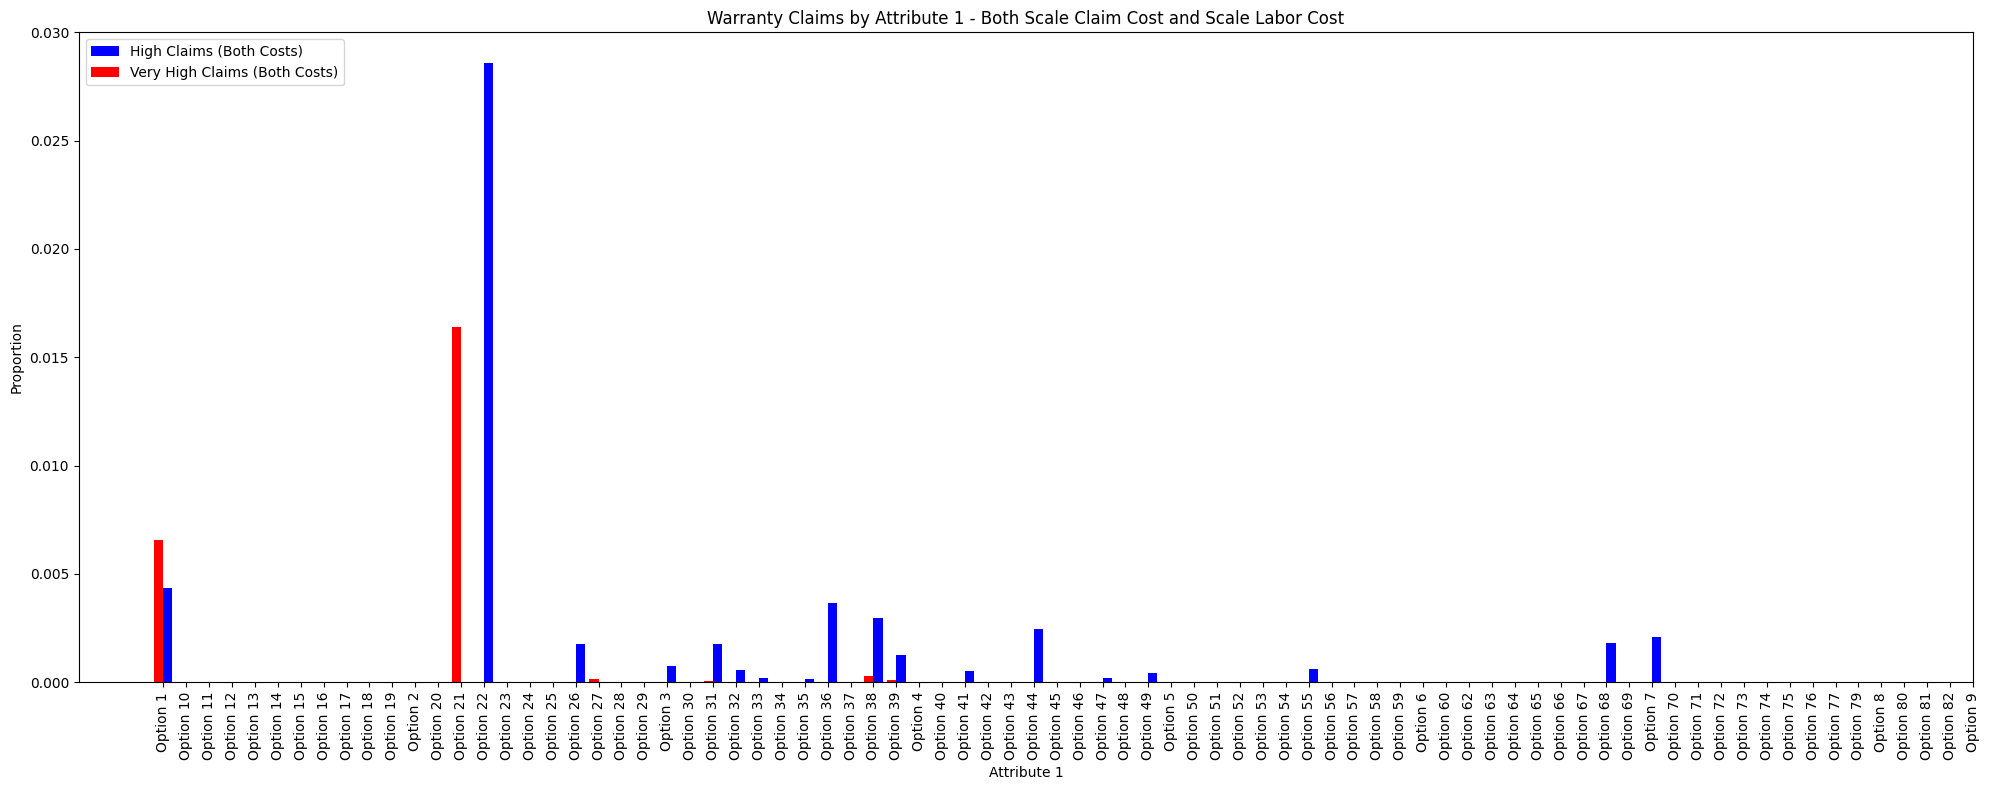

<BarContainer object of 94 artists>

<BarContainer object of 94 artists>

[Text(0, 0, 'Option 100'),
 Text(1, 0, 'Option 101'),
 Text(2, 0, 'Option 102'),
 Text(3, 0, 'Option 103'),
 Text(4, 0, 'Option 104'),
 Text(5, 0, 'Option 105'),
 Text(6, 0, 'Option 106'),
 Text(7, 0, 'Option 107'),
 Text(8, 0, 'Option 108'),
 Text(9, 0, 'Option 109'),
 Text(10, 0, 'Option 110'),
 Text(11, 0, 'Option 111'),
 Text(12, 0, 'Option 112'),
 Text(13, 0, 'Option 113'),
 Text(14, 0, 'Option 114'),
 Text(15, 0, 'Option 115'),
 Text(16, 0, 'Option 116'),
 Text(17, 0, 'Option 117'),
 Text(18, 0, 'Option 118'),
 Text(19, 0, 'Option 119'),
 Text(20, 0, 'Option 120'),
 Text(21, 0, 'Option 121'),
 Text(22, 0, 'Option 122'),
 Text(23, 0, 'Option 123'),
 Text(24, 0, 'Option 124'),
 Text(25, 0, 'Option 125'),
 Text(26, 0, 'Option 126'),
 Text(27, 0, 'Option 127'),
 Text(28, 0, 'Option 128'),
 Text(29, 0, 'Option 130'),
 Text(30, 0, 'Option 131'),
 Text(31, 0, 'Option 132'),
 Text(32, 0, 'Option 133'),
 Text(33, 0, 'Option 134'),
 Text(34, 0, 'Option 135'),
 Text(35, 0, 'Option 136'),
 T

Text(0.5, 1.0, 'Warranty Claims by Attribute 2 - Both Scale Claim Cost and Scale Labor Cost')

Text(0.5, 0, 'Attribute 2')

Text(0, 0.5, 'Proportion')

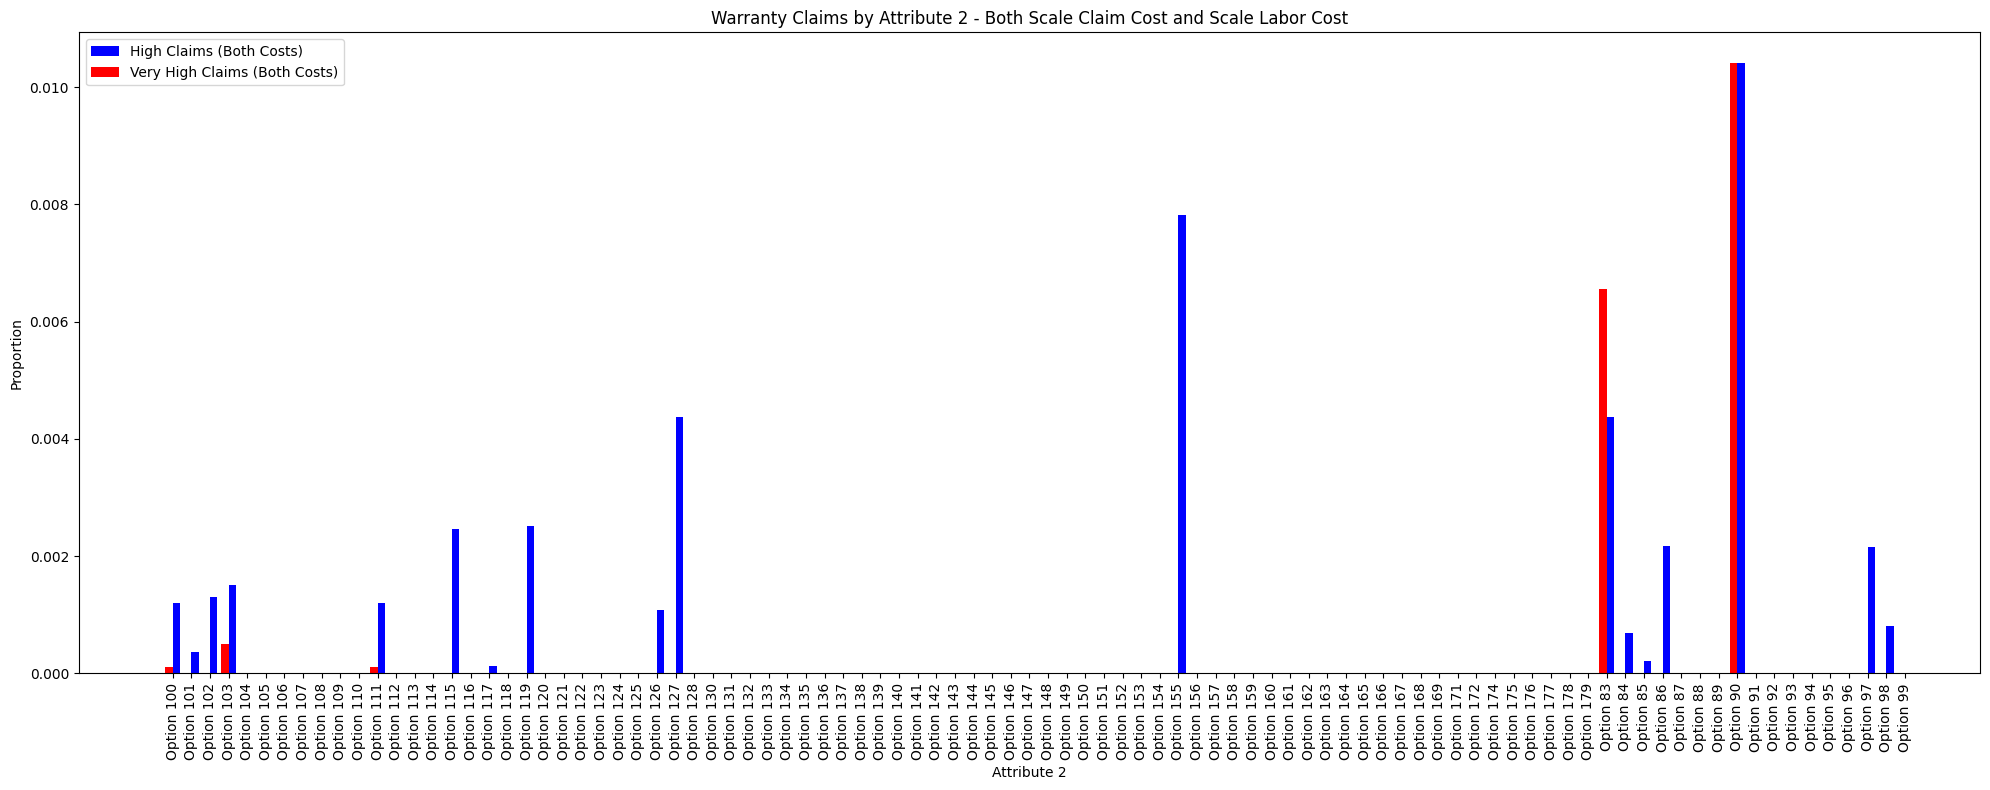

<BarContainer object of 21 artists>

<BarContainer object of 21 artists>

[Text(0, 0, 'Option 181'),
 Text(1, 0, 'Option 182'),
 Text(2, 0, 'Option 183'),
 Text(3, 0, 'Option 184'),
 Text(4, 0, 'Option 185'),
 Text(5, 0, 'Option 186'),
 Text(6, 0, 'Option 187'),
 Text(7, 0, 'Option 188'),
 Text(8, 0, 'Option 189'),
 Text(9, 0, 'Option 190'),
 Text(10, 0, 'Option 191'),
 Text(11, 0, 'Option 192'),
 Text(12, 0, 'Option 193'),
 Text(13, 0, 'Option 194'),
 Text(14, 0, 'Option 195'),
 Text(15, 0, 'Option 196'),
 Text(16, 0, 'Option 198'),
 Text(17, 0, 'Option 199'),
 Text(18, 0, 'Option 200'),
 Text(19, 0, 'Option 201'),
 Text(20, 0, 'Option 203')]

Text(0.5, 1.0, 'Warranty Claims by Attribute 3 - Both Scale Claim Cost and Scale Labor Cost')

Text(0.5, 0, 'Attribute 3')

Text(0, 0.5, 'Proportion')

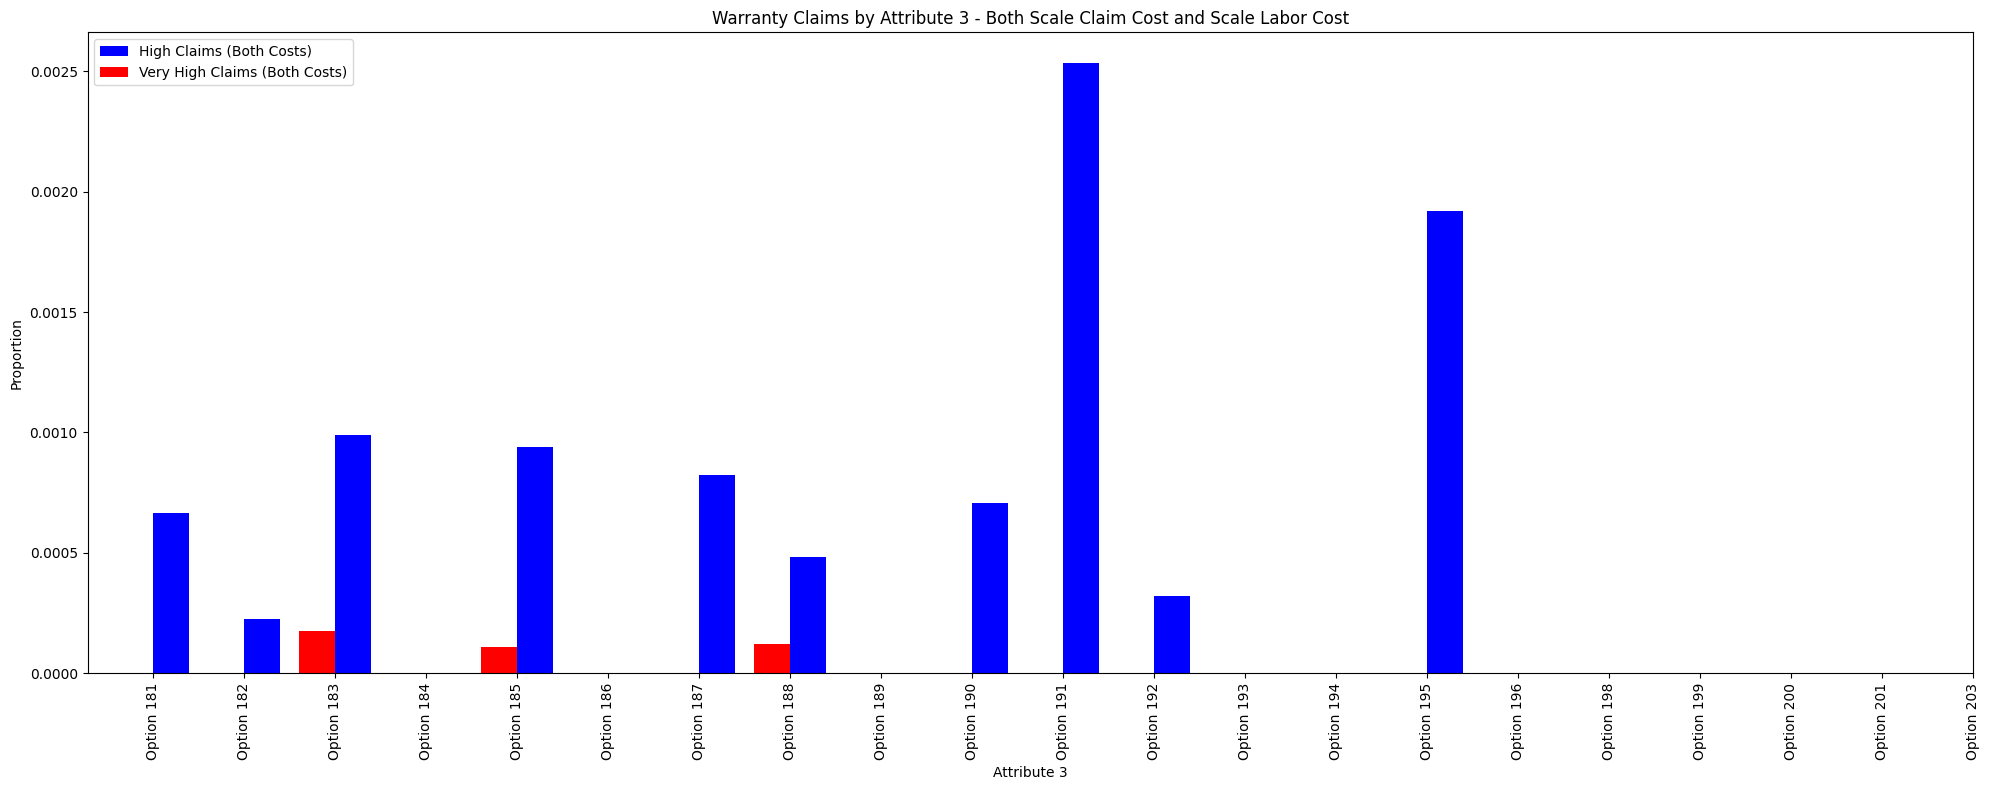

<BarContainer object of 56 artists>

<BarContainer object of 56 artists>

[Text(0, 0, 'Option 204'),
 Text(1, 0, 'Option 205'),
 Text(2, 0, 'Option 206'),
 Text(3, 0, 'Option 207'),
 Text(4, 0, 'Option 208'),
 Text(5, 0, 'Option 209'),
 Text(6, 0, 'Option 210'),
 Text(7, 0, 'Option 211'),
 Text(8, 0, 'Option 212'),
 Text(9, 0, 'Option 213'),
 Text(10, 0, 'Option 214'),
 Text(11, 0, 'Option 215'),
 Text(12, 0, 'Option 216'),
 Text(13, 0, 'Option 217'),
 Text(14, 0, 'Option 218'),
 Text(15, 0, 'Option 219'),
 Text(16, 0, 'Option 220'),
 Text(17, 0, 'Option 221'),
 Text(18, 0, 'Option 222'),
 Text(19, 0, 'Option 223'),
 Text(20, 0, 'Option 224'),
 Text(21, 0, 'Option 225'),
 Text(22, 0, 'Option 226'),
 Text(23, 0, 'Option 227'),
 Text(24, 0, 'Option 228'),
 Text(25, 0, 'Option 229'),
 Text(26, 0, 'Option 230'),
 Text(27, 0, 'Option 231'),
 Text(28, 0, 'Option 232'),
 Text(29, 0, 'Option 233'),
 Text(30, 0, 'Option 234'),
 Text(31, 0, 'Option 235'),
 Text(32, 0, 'Option 236'),
 Text(33, 0, 'Option 237'),
 Text(34, 0, 'Option 238'),
 Text(35, 0, 'Option 239'),
 T

Text(0.5, 1.0, 'Warranty Claims by Attribute 4 - Both Scale Claim Cost and Scale Labor Cost')

Text(0.5, 0, 'Attribute 4')

Text(0, 0.5, 'Proportion')

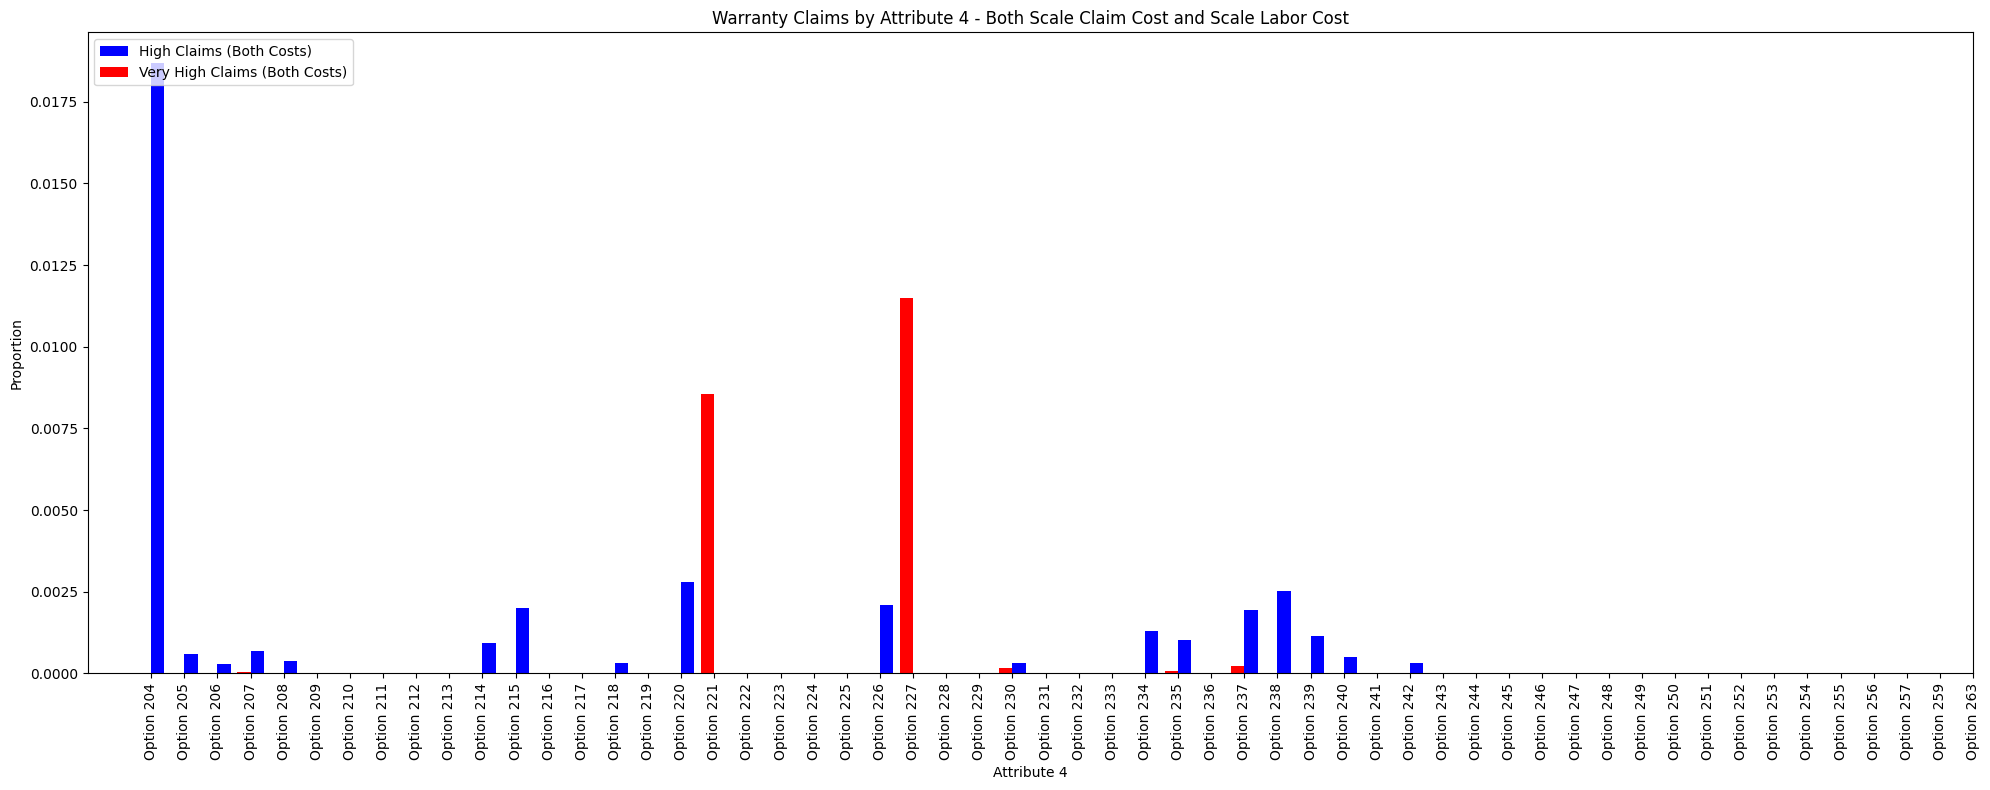

<BarContainer object of 16 artists>

<BarContainer object of 16 artists>

[Text(0, 0, 'Option 264'),
 Text(1, 0, 'Option 265'),
 Text(2, 0, 'Option 266'),
 Text(3, 0, 'Option 267'),
 Text(4, 0, 'Option 268'),
 Text(5, 0, 'Option 269'),
 Text(6, 0, 'Option 270'),
 Text(7, 0, 'Option 271'),
 Text(8, 0, 'Option 272'),
 Text(9, 0, 'Option 273'),
 Text(10, 0, 'Option 274'),
 Text(11, 0, 'Option 275'),
 Text(12, 0, 'Option 276'),
 Text(13, 0, 'Option 277'),
 Text(14, 0, 'Option 279'),
 Text(15, 0, 'Option 280')]

Text(0.5, 1.0, 'Warranty Claims by Attribute 5 - Both Scale Claim Cost and Scale Labor Cost')

Text(0.5, 0, 'Attribute 5')

Text(0, 0.5, 'Proportion')

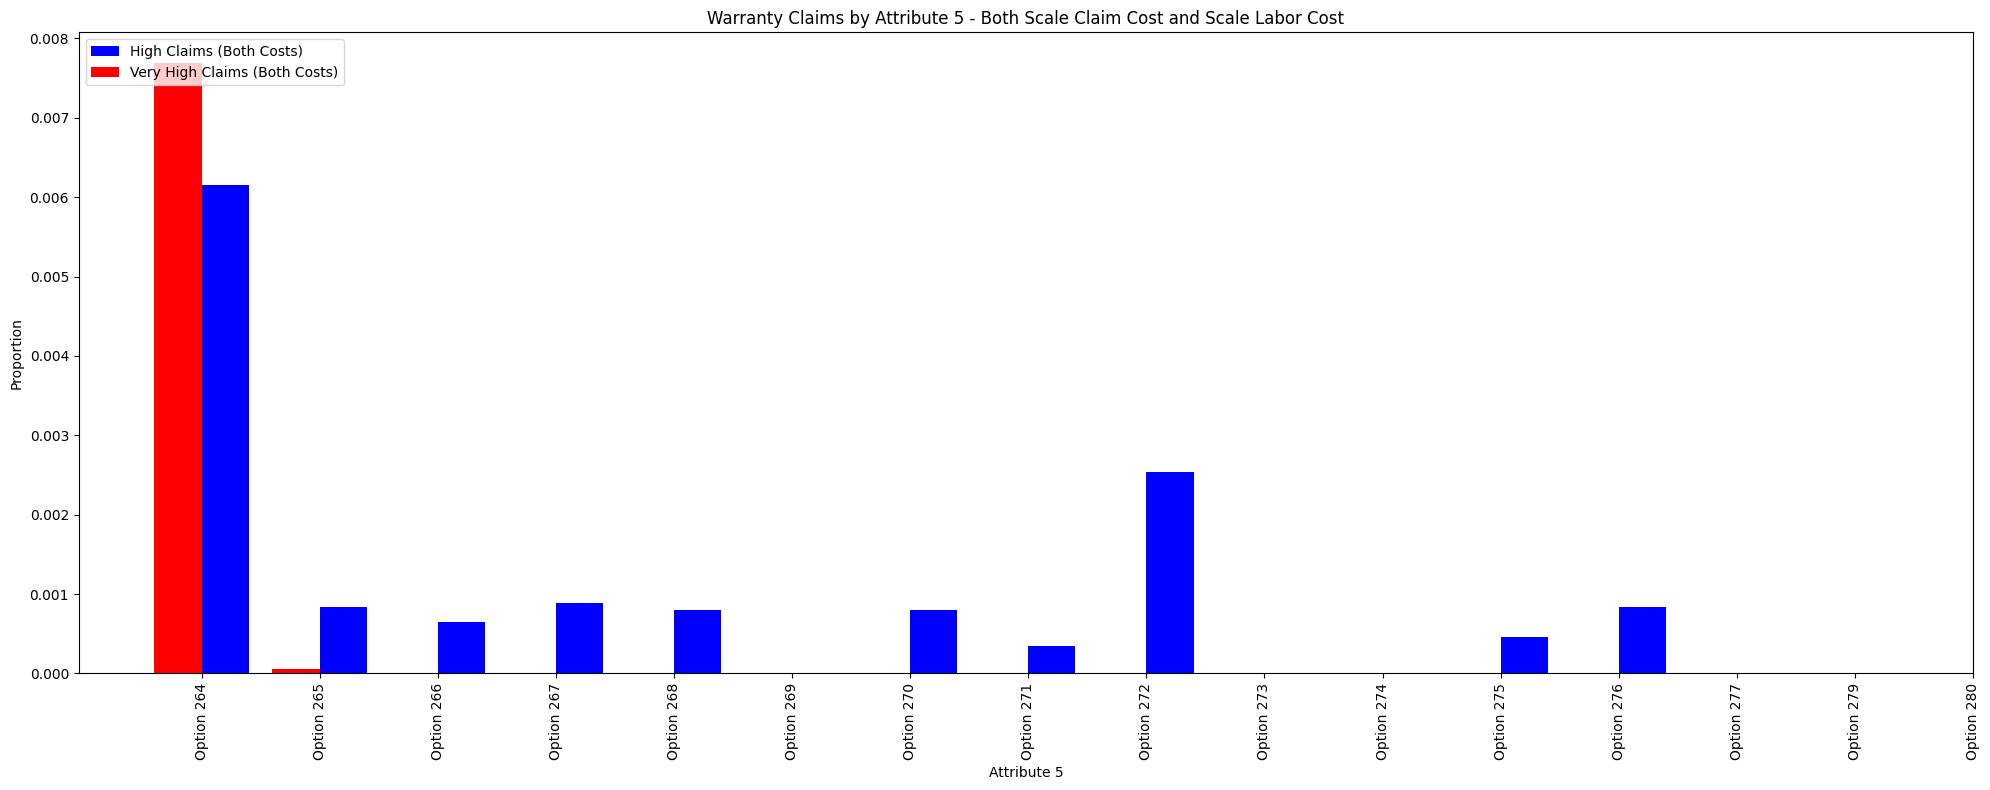

<BarContainer object of 9 artists>

<BarContainer object of 9 artists>

[Text(0, 0, 'Option 281'),
 Text(1, 0, 'Option 282'),
 Text(2, 0, 'Option 284'),
 Text(3, 0, 'Option 285'),
 Text(4, 0, 'Option 286'),
 Text(5, 0, 'Option 287'),
 Text(6, 0, 'Option 288'),
 Text(7, 0, 'Option 289'),
 Text(8, 0, 'Option283')]

Text(0.5, 1.0, 'Warranty Claims by Attribute 6 - Both Scale Claim Cost and Scale Labor Cost')

Text(0.5, 0, 'Attribute 6')

Text(0, 0.5, 'Proportion')

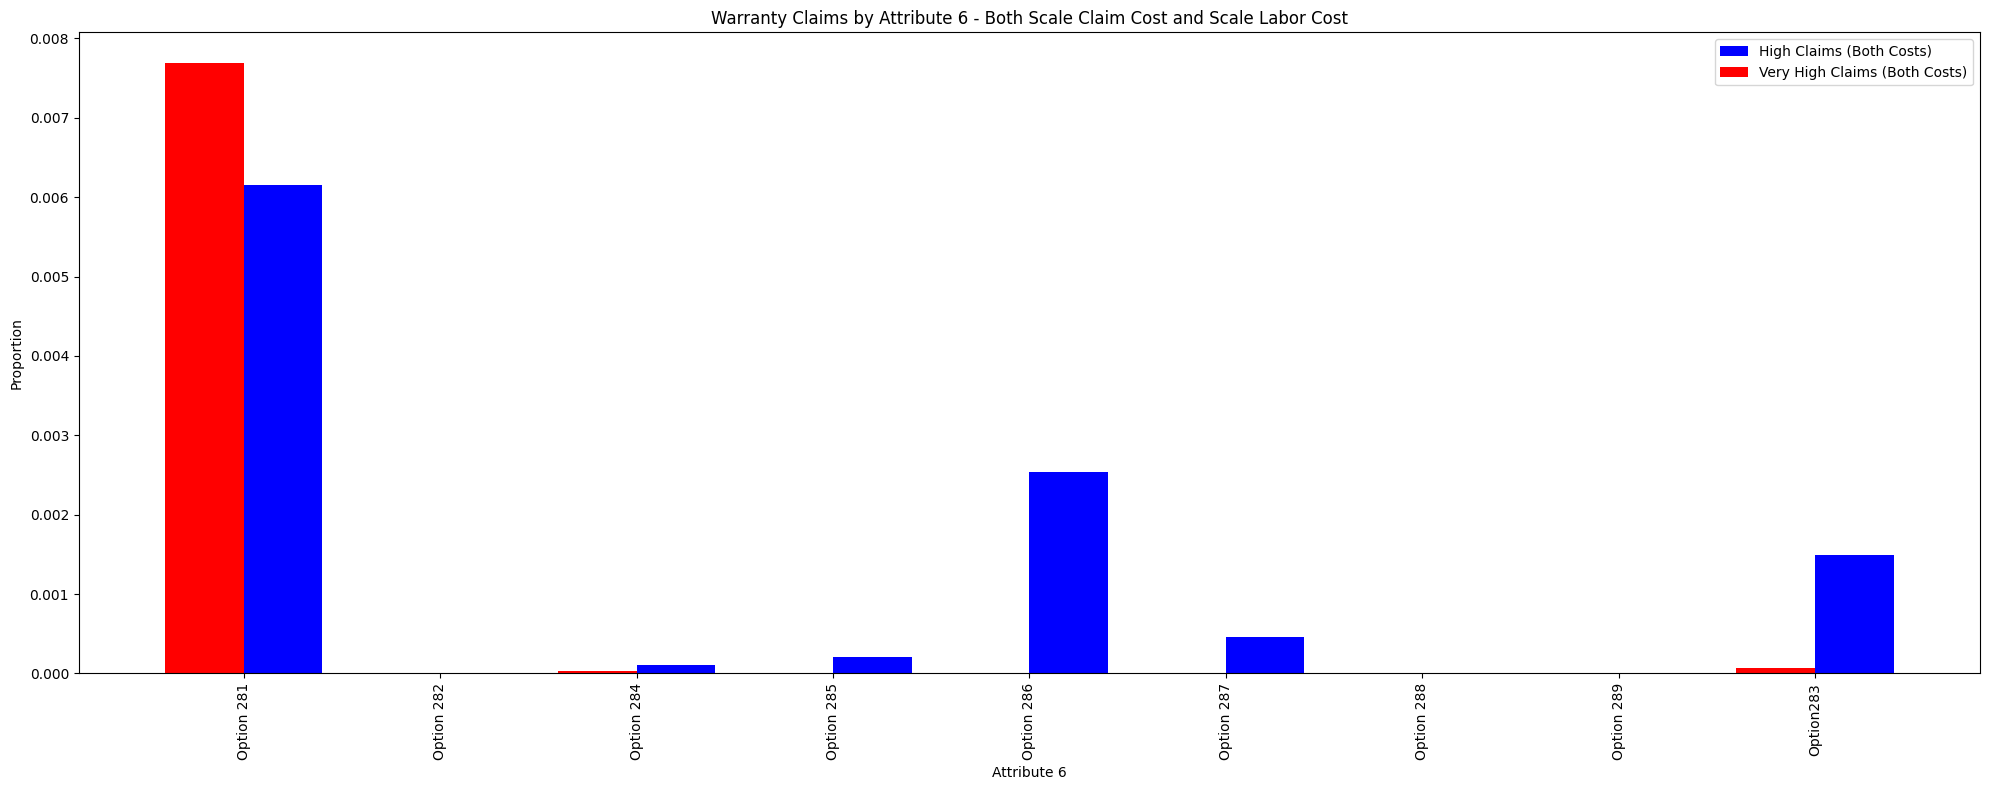

<BarContainer object of 4 artists>

<BarContainer object of 4 artists>

[Text(0, 0, 'Option 290'),
 Text(1, 0, 'Option 291'),
 Text(2, 0, 'Option 292'),
 Text(3, 0, 'Option 293')]

Text(0.5, 1.0, 'Warranty Claims by Attribute 7 - Both Scale Claim Cost and Scale Labor Cost')

Text(0.5, 0, 'Attribute 7')

Text(0, 0.5, 'Proportion')

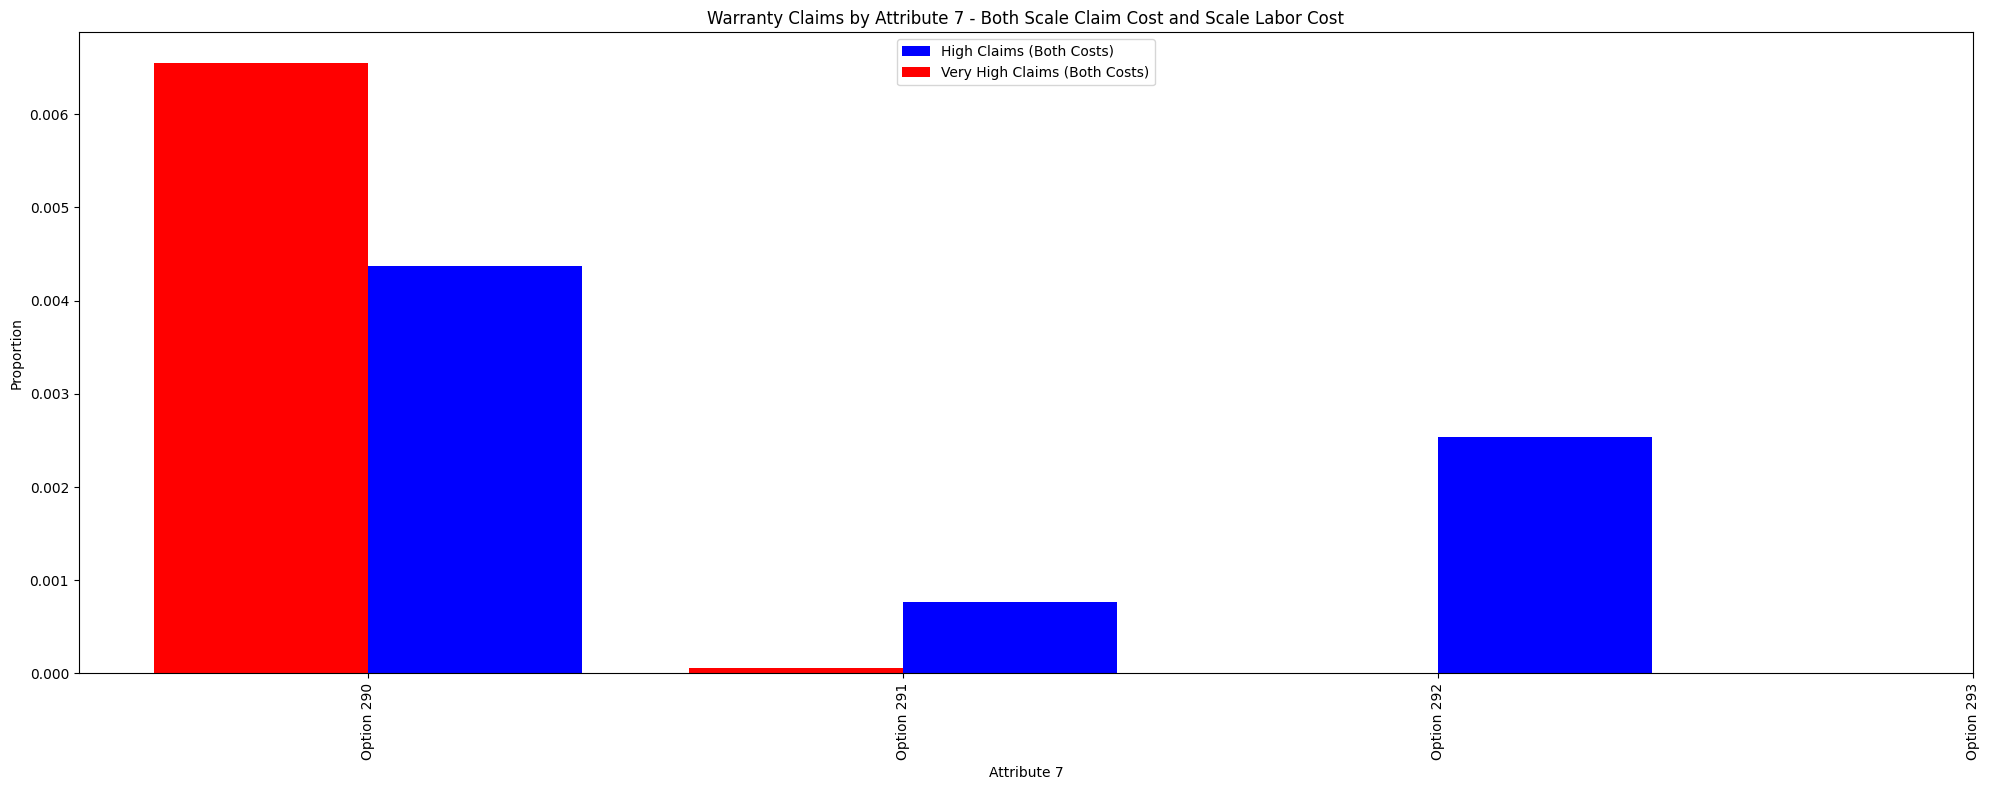

<BarContainer object of 21 artists>

<BarContainer object of 21 artists>

[Text(0, 0, 'Option 294'),
 Text(1, 0, 'Option 295'),
 Text(2, 0, 'Option 296'),
 Text(3, 0, 'Option 297'),
 Text(4, 0, 'Option 298'),
 Text(5, 0, 'Option 299'),
 Text(6, 0, 'Option 300'),
 Text(7, 0, 'Option 301'),
 Text(8, 0, 'Option 302'),
 Text(9, 0, 'Option 303'),
 Text(10, 0, 'Option 304'),
 Text(11, 0, 'Option 305'),
 Text(12, 0, 'Option 306'),
 Text(13, 0, 'Option 307'),
 Text(14, 0, 'Option 308'),
 Text(15, 0, 'Option 309'),
 Text(16, 0, 'Option 310'),
 Text(17, 0, 'Option 311'),
 Text(18, 0, 'Option 312'),
 Text(19, 0, 'Option 313'),
 Text(20, 0, 'Option 314')]

Text(0.5, 1.0, 'Warranty Claims by Attribute 8 - Both Scale Claim Cost and Scale Labor Cost')

Text(0.5, 0, 'Attribute 8')

Text(0, 0.5, 'Proportion')

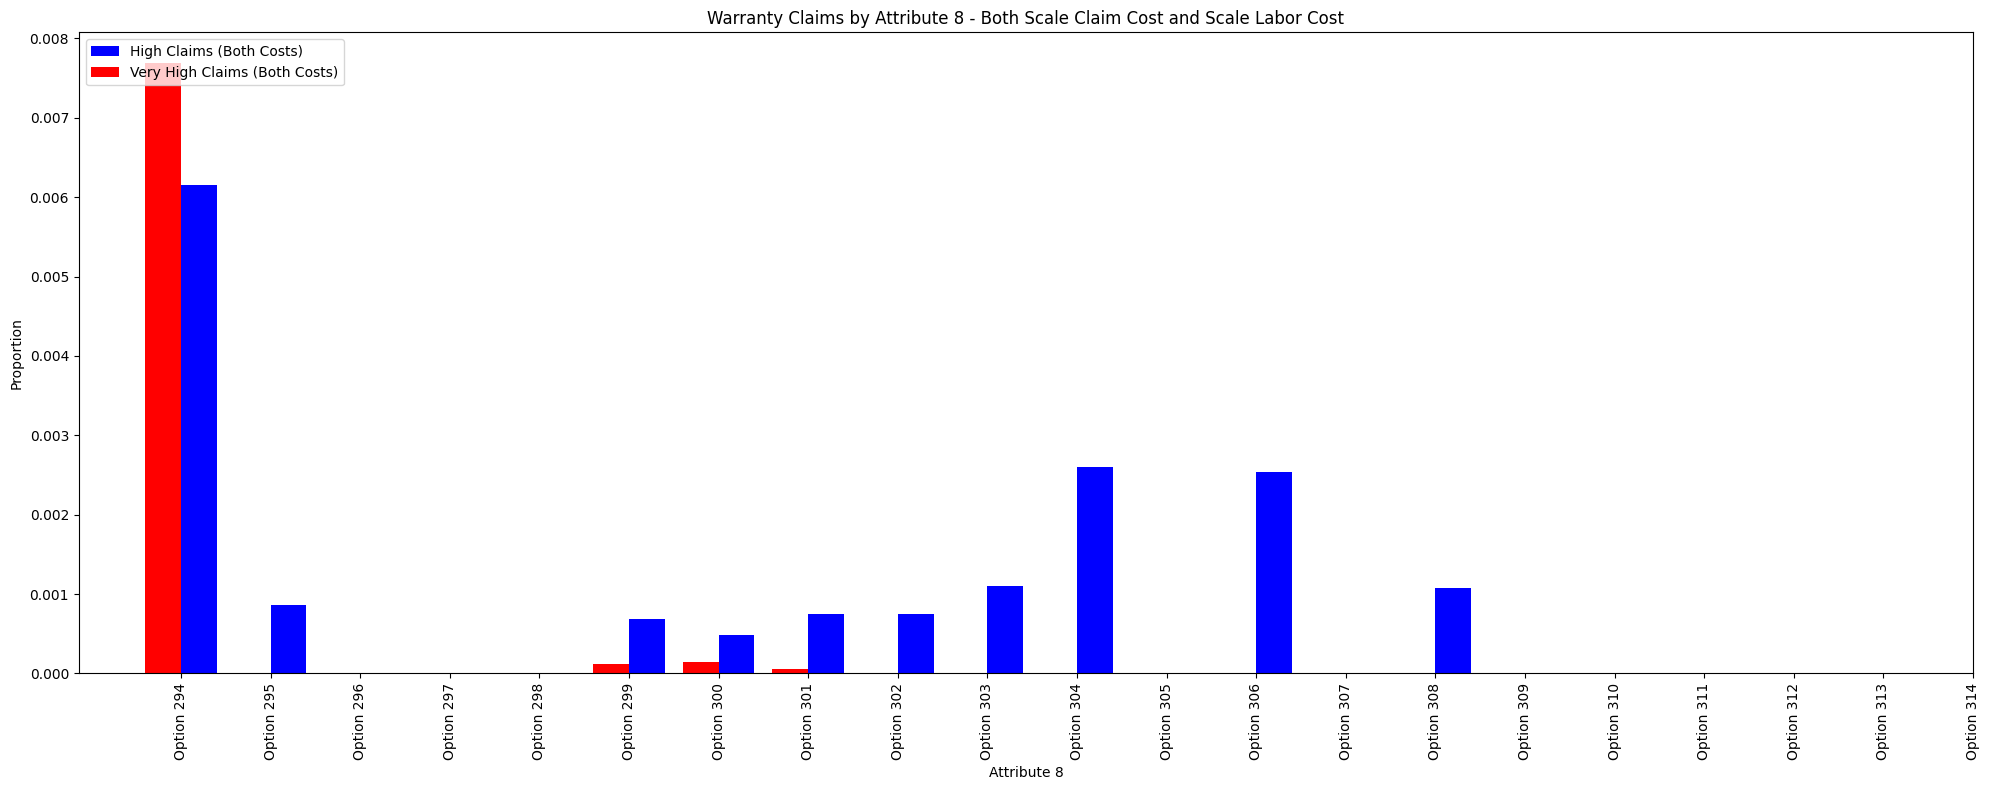

In [11]:
# This is for which option/subpart for each attribute is associated with increased warranty costs

# Define attribute columns to loop through
attributes = [f'Attribute {i}' for i in range(1, 9)]

for attr in attributes:
    # Calculate proportions of claims where both Scale Claim Cost and Scale Labor Cost are 'High'
    high_claims = merged_data[(merged_data['Scale Claim Cost'] == 'High') & 
                              (merged_data['Scale Labor Cost'] == 'High')].groupby(attr).size() / merged_data.groupby(attr).size()
    
    # Calculate proportions of claims where both Scale Claim Cost and Scale Labor Cost are 'Very High'
    very_high_claims = merged_data[(merged_data['Scale Claim Cost'] == 'Very High') & 
                                   (merged_data['Scale Labor Cost'] == 'Very High')].groupby(attr).size() / merged_data.groupby(attr).size()

    # Plot
    fig, ax = plt.subplots(figsize=(20, 8))
    positions = range(len(high_claims))
    ax.bar([x + 0.2 for x in positions], high_claims, width=0.4, label='High Claims (Both Costs)', color='blue')
    ax.bar([x - 0.2 for x in positions], very_high_claims, width=0.4, label='Very High Claims (Both Costs)', color='red')
    ax.set_xticks(positions)
    ax.set_xticklabels(high_claims.index, rotation=90, ha='center')
    ax.set_title(f'Warranty Claims by {attr} - Both Scale Claim Cost and Scale Labor Cost')
    ax.set_xlabel(attr)
    ax.set_ylabel('Proportion')
    ax.legend()
    plt.tight_layout()
    plt.show()


<Axes: >

Text(0.5, 1.0, 'Version 2: Average Proportion of High Claims by Attribute Pair (Both Costs)')

Text(0.5, 58.7222222222222, 'Attributes')

Text(170.72222222222223, 0.5, 'Attributes')

<Axes: >

Text(0.5, 1.0, 'Version 2: Average Proportion of Very High Claims by Attribute Pair (Both Costs)')

Text(0.5, 58.7222222222222, 'Attributes')

Text(847.0858585858584, 0.5, 'Attributes')

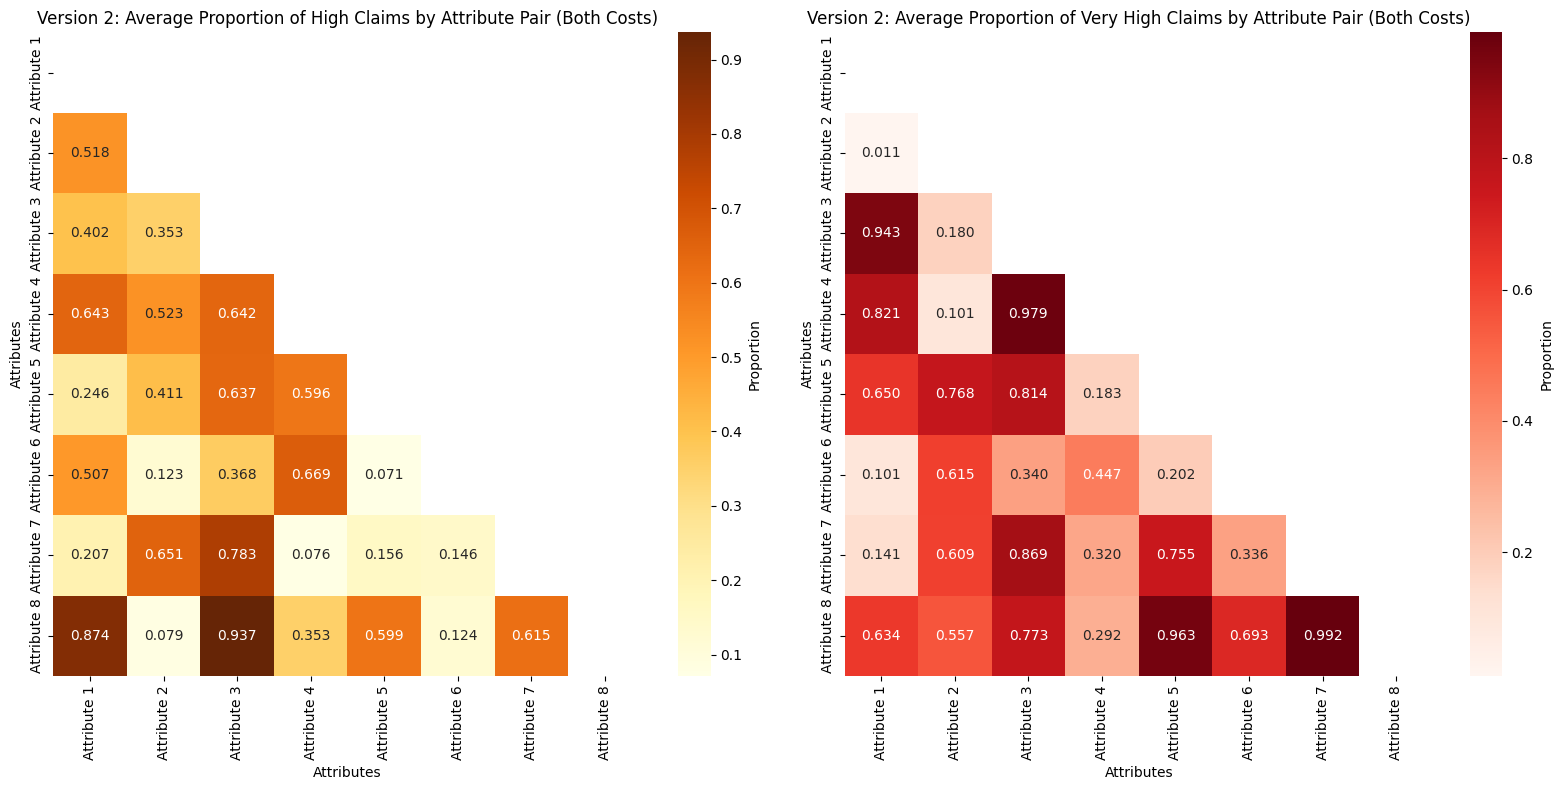

In [12]:
# what specific pairs of attribute/component when combines can exacerbates warranty claims.

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Define the attribute columns
attributes = [f'Attribute {i}' for i in range(1, 9)]

# Sample data creation for demonstration (replace with actual high_matrix_v2 and very_high_matrix_v2 calculations)
data_high_v2 = np.random.rand(8, 8)
data_very_high_v2 = np.random.rand(8, 8)
high_matrix_v2 = pd.DataFrame(data_high_v2, index=attributes, columns=attributes)
very_high_matrix_v2 = pd.DataFrame(data_very_high_v2, index=attributes, columns=attributes)

# Masking the upper triangle for a lower-triangle heatmap
mask = np.triu(np.ones_like(high_matrix_v2, dtype=bool))

# Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# High Claims Heatmap for Version 2
sns.heatmap(high_matrix_v2, mask=mask, annot=True, cmap="YlOrBr", fmt=".3f", ax=ax1, cbar_kws={'label': 'Proportion'})
ax1.set_title("Version 2: Average Proportion of High Claims by Attribute Pair (Both Costs)")
ax1.set_xlabel("Attributes")
ax1.set_ylabel("Attributes")

# Very High Claims Heatmap for Version 2
sns.heatmap(very_high_matrix_v2, mask=mask, annot=True, cmap="Reds", fmt=".3f", ax=ax2, cbar_kws={'label': 'Proportion'})
ax2.set_title("Version 2: Average Proportion of Very High Claims by Attribute Pair (Both Costs)")
ax2.set_xlabel("Attributes")
ax2.set_ylabel("Attributes")

plt.tight_layout()
plt.show()


In [14]:
# Identify Styles and Trucks Associated with Increased Warranty Costs

# Filter data for both Scale Claim Cost and Scale Labor Cost as High or Very High
high_claims_v2 = merged_data[(merged_data['Scale Claim Cost'] == 'High') & (merged_data['Scale Labor Cost'] == 'High')]
very_high_claims_v2 = merged_data[(merged_data['Scale Claim Cost'] == 'Very High') & (merged_data['Scale Labor Cost'] == 'Very High')]

# Group by Style and Truck_ID to get proportions for each attribute with High and Very High claims
high_claims_by_style_v2 = high_claims_v2.groupby(['Style', 'Truck_ID']).size() / merged_data.groupby(['Style', 'Truck_ID']).size()
very_high_claims_by_style_v2 = very_high_claims_v2.groupby(['Style', 'Truck_ID']).size() / merged_data.groupby(['Style', 'Truck_ID']).size()

# Display top 10 trucks with highest proportion of high and very high claim costs
print("Version 2: Top 10 Trucks with High Claim Costs (Both Costs)")
print(high_claims_by_style_v2.sort_values(ascending=False).head(10))

print("\nVersion 2: Top 10 Trucks with Very High Claim Costs (Both Costs)")
print(very_high_claims_by_style_v2.sort_values(ascending=False).head(10))


Version 2: Top 10 Trucks with High Claim Costs (Both Costs)
Style    Truck_ID   
Style 1  Truck 1672     1.0
Style 3  Truck 39782    1.0
Style 7  Truck 7609     1.0
Style 4  Truck 36259    1.0
Style 7  Truck 23293    1.0
         Truck 38314    1.0
Style 4  Truck 3624     0.5
Style 7  Truck 13198    0.5
         Truck 29489    0.5
Style 4  Truck 40292    0.5
dtype: float64

Version 2: Top 10 Trucks with Very High Claim Costs (Both Costs)
Style    Truck_ID   
Style 4  Truck 10450    1.000000
         Truck 47716    0.250000
Style 7  Truck 36211    0.200000
Style 2  Truck 1929     0.166667
         Truck 1932     0.125000
Style 4  Truck 47717    0.125000
Style 3  Truck 38729    0.111111
Style 4  Truck 44270    0.100000
         Truck 6225     0.090909
Style 8  Truck 22772    0.083333
dtype: float64


In [15]:
# Identify Trucks with Most Claims

# Filter data for claims where either Scale Claim Cost or Scale Labor Cost is High or Very High
combined_claims_v2 = merged_data[((merged_data['Scale Claim Cost'] == 'High') | (merged_data['Scale Claim Cost'] == 'Very High')) |
                                 ((merged_data['Scale Labor Cost'] == 'High') | (merged_data['Scale Labor Cost'] == 'Very High'))]

# Count the total number of claims per Truck and Style
claims_by_truck_v2 = combined_claims_v2.groupby(['Style', 'Truck_ID']).size()

# Display top 10 trucks with the most claims based on both costs
print("Version 2: Top 10 Trucks with Most Warranty Claims (Both Costs)")
print(claims_by_truck_v2.sort_values(ascending=False).head(10))


Version 2: Top 10 Trucks with Most Warranty Claims (Both Costs)
Style    Truck_ID   
Style 4  Truck 29586    6
         Truck 21774    6
         Truck 28145    5
         Truck 29585    5
         Truck 8067     4
Style 3  Truck 16888    4
Style 4  Truck 26029    4
         Truck 25702    4
         Truck 46939    4
         Truck 3141     4
dtype: int64
